# Assignment 3 (Group 2)

Building a recommender system

## Index

- [Introduction](#s1)
- [System Design](#s2)
- [Dataset](#s3)
- [Data cleaning](#s4)
- [Exploratory Analysis](#s5)
- [Frequent Pattern Mining](#s6)
    - [Measuring performance of FP-Growth and Apriori](#f1)
    - [Determining the support thresholds](#f2)
    - [Evaluating Association rules](#f3)
- [Collaborative Filters](#s7)
    - [Collaborative filtering models](#f5)
        - [Baseline model](#c1)
        - [K-Nearest Neighbours based method](#c2)
            - [Clustering](#q1)
            - [KNN Collaborative Filter implementation and hyperparmeter tuning](#w1)        
    - [Singular Value Decomposition](#w2)
- [Combined Approach](#s8)
- [Results](#s9)
    - [Evaluating Model Fit using RMSE and MAE](#r1)
    - [Evaluating Quality of Recommendations](#r2) 
    - [T-test to compare models](#r3)
- [Prediction Samples](#r4)
- [Discussions](#s10)
- [Deployment and Scalability](#s11)
- [References](#s12)

## Introduction <a id="s1"></a>

We will build a recommender system capable of recommending items to users based on their buying preferences. We will be using a collaborative filter to recommend the items and make use of association rules to improve the recommendations made. A comparision of the baselines and other methods among with the proposed method is made.

## System Design <a id="s2"></a>

We propose to use clustered association rules to reduce the sparsity in the matrix, and then train a user-based collaborative filter as shown in the figure below.

![flow%20chart.png](attachment:flow%20chart.png "Proposed Recommender System")
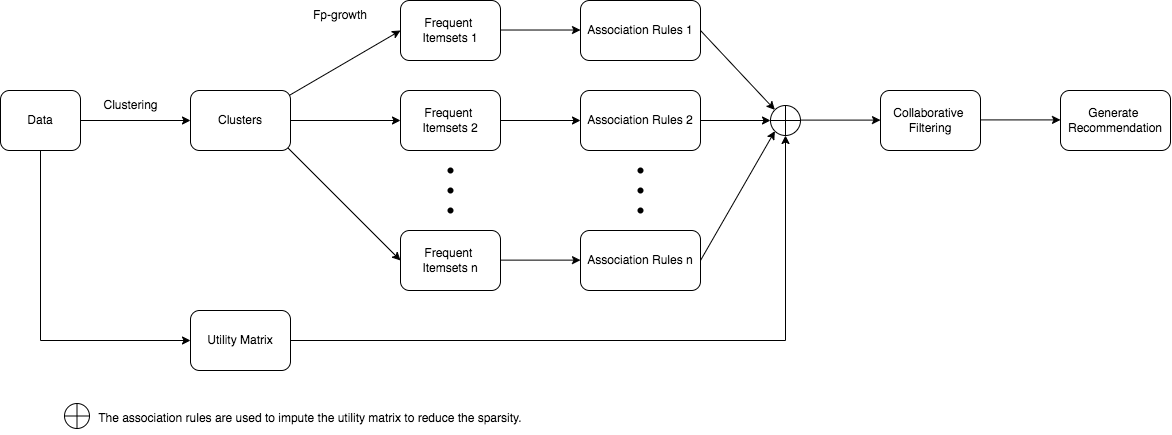

## Dataset <a id="s3"></a>

 The dataset contains the two years worth of transactions information of the customers in a grocery store between 2014 to 2015. We read the csv file of training data and testing data as Dataframe. 

In [1]:
# import libraries
import pandas as pd
import numpy as np

# importing plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# importing type annotations
from typing import List, Tuple, Callable

# to build function pipelines
from toolz import pipe

# supress warnings
import warnings
warnings.filterwarnings("ignore")

Loading the raw training and testing dataset in a DataFrame

In [2]:
# load raw train and test datasets
train_data_raw = pd.read_csv("Groceries data train.csv")
test_data_raw = pd.read_csv("Groceries data test.csv")

Viewing the train dataset

In [3]:
# viewing first 5 rows of the training dataset
train_data_raw.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3021,30/01/2015,frankfurter,2015,1,30,4
1,1292,24/10/2015,pork,2015,10,24,5
2,4206,4/04/2014,root vegetables,2014,4,4,4
3,4369,25/08/2015,onions,2015,8,25,1
4,1522,1/07/2014,waffles,2014,7,1,1


In [4]:
# viewing first 5 rows of the testing dataset
test_data_raw.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3481,8/03/2015,candy,2015,3,8,6
1,1254,19/04/2015,white wine,2015,4,19,6
2,2835,28/01/2014,domestic eggs,2014,1,28,1
3,2854,2/08/2015,coffee,2015,8,2,6
4,4637,12/08/2014,bottled water,2014,8,12,1


The dataset information mainly consists of Member_number, Date, and itemDescription. Each cumtomer has a specific Member_number. The itemDescription shows the item that a particular customer bought on that Date in one transaction. Other information such as year, month, day, and day_of_week are just derived from the Date. 

## Data cleaning <a id="s4"></a>

We see that year, month, day and day_of_week are derived columns from Date, therefore we will drop them and further rename the column names to cleaner names. We will also change the data type of Date to datetime with the following function which can then be used to apply it on testing set as well

A function to preprocess the dataset

In [5]:
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the raw data to a cleaner format
    
    Parameters:
        data : pd.DataFrame
            The raw dataframe as input from csv files
            
    Returns
        pd.DataFrame
            The dataframe with cleaned columns
    """
    return (data
            # derive new columns
            .assign(date = pd.to_datetime(data["Date"]),
                    userID = data["Member_number"],
                    itemID = data["itemDescription"]
                   )
            # subset new columns
            [['userID', 'date', 'itemID']]
           )

A function to generate utility matrix with counts as the rating

In [6]:
def generate_utility_matrix(data: pd.DataFrame) -> pd.DataFrame:
    """
    Generates the utility matrix for the given data with
    users as index and items as the columns
    
    Parameters:
        data: pd.DataFrame
            A dataframe with "userID" and "itemID" for a purchase
    
    Returns:
        pd.DataFrame
            Utility matrix of users * items
    """
    
    return (preprocess_CF_data(train_data)
            .pivot_table(values="rating", 
                         index="userID",
                         columns="itemID",
                         fill_value=0,
                         aggfunc="count"))

We will use the above function to get the cleaned versions of the raw training and testing datasets

In [7]:
# preprocess datasets
train_data = preprocess_data(train_data_raw)
test_data = preprocess_data(test_data_raw)

# viewing the data to confirm the exepected operations
train_data.head()

,userID,date,itemID
0,3021,2015-01-30,frankfurter
1,1292,2015-10-24,pork
2,4206,2014-04-04,root vegetables
3,4369,2015-08-25,onions
4,1522,2014-01-07,waffles


## Exploratory analysis <a id="s5"></a>

Getting the number of observations in training data

In [8]:
# viewing the size of training data
train_data.shape

(27000, 3)

In [9]:
# viewing the size of test data
test_data.shape

(11765, 3)

We observe that the training data has 27000 observations and the testing data has 11765 observation for individual items bought at the store

In [10]:
# getting the unique number of items
train_data["itemID"].nunique()

167

We have 167 unique items in the training dataset

In [11]:
# getting the number of users
train_data["userID"].nunique()

3872

Of the 27000 individual items bought we had 3872 unique customers who bought from the set of 167 available items

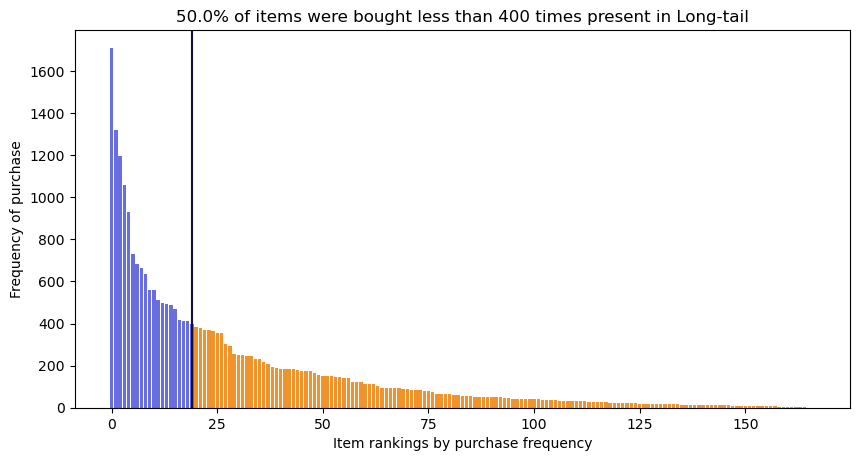

In [12]:
# getting frequency of items bought
item_frequency = train_data["itemID"].value_counts()

# identifying threshold for 50% of total items bought by item rankings
buying_threshold = 0.5
cumulative_freq_products = np.cumsum(item_frequency)
popularity_threshold_item = len(cumulative_freq_products[cumulative_freq_products < item_frequency.sum()*buying_threshold])
popularity_threshold = item_frequency[popularity_threshold_item+1]


# Setting figure size and ploting the count using a bar chart
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

# Setting color for popular and unpopular items
popular_color = 'red'
unpopular_color = 'black'


# Plotting the count of each unique item by separting them with refrence to popularity threshold
for i in range(len(item_frequency)):
    if item_frequency[i] >= popularity_threshold:
        ax.bar(i, item_frequency[i], color="#686de0")
    else:
        ax.bar(i, item_frequency[i], color="#f0932b")

# Setting labels and title
ax.set_xlabel('Item rankings by purchase frequency')
ax.set_ylabel('Frequency of purchase')
ax.set_title(f'{(1-buying_threshold)*100}% of items were bought less than {popularity_threshold} times present in Long-tail')

# adding a horizontal line to separate popular and unpopular items
n_popular_items = sum(item_frequency > popularity_threshold)
ax.axvline(x=n_popular_items, color="#130f40")

# saving the plot
plt.savefig("Longtail.png")

From above plot we can see that 50% of the items bought make up more than half of the products sold, showing a strong long tail problem. Which indicates that using a recommender system can generate profit by utilizing the sales of these less popular items as well.

## Frequent pattern mining <a id="s6"></a>

Importing [mlxtend](https://pypi.org/project/mlxtend/) library to mine association rules

In [ ]:
# importing association rules mining libraries
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

A function to generate the transaction-item encoder matrix

In [ ]:
def get_encoder_matrix(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Get the TransactionEncoder matrix to be used for mining frequent itemset
    
    Parameters:
    dataset : pd.DataFrame
            A DataFrame containing columns of "userID", "itemID", and "date"

    Returns:
        pd.DataFrame
            A DataFrame where each row represents a transaction and each column represents an item.
            If the item was bought, the corresponding cell is set to True, otherwise False.
    """
    
    # getting list of items for each transaction
    daily_transactions = (dataset
                          .groupby(by=['userID', 'date'])['itemID']
                          .agg(lambda x: list(x)))
    
    # Transform transaction data into a one-hot encoded format
    trans_encoder = TransactionEncoder() # Instantiate the encoder
    trans_encoder_matrix = trans_encoder.fit(daily_transactions).transform(daily_transactions)
    trans_encoder_matrix = pd.DataFrame(trans_encoder_matrix, columns=trans_encoder.columns_)
    
    return trans_encoder_matrix    

Creating the transaction encoder matrix from the training data to find association rules

In [ ]:
# generating the encoder matrix
trans_encoder_matrix = get_encoder_matrix(train_data)

# viewing the transcation encoder matrix
trans_encoder_matrix

In [ ]:
def get_frequent_itemset(data: pd.DataFrame, 
                          algorithm: str="fp-growth",
                          min_support: float=0.0006) -> pd.DataFrame:
    """
    Get the the frequent itemsets 
    
    Parameters:
    data : pd.DataFrame
            A DataFrame containing columns of "userID", "itemID", and "date"

    algorithm: str
            A string specifying the algorithm used (e.g. fp-growth, apriori)

    min_support: float
            A flaot number specifying the support threshold for mining frequent itemsets

    Returns:
        pd.DataFrame
            A DataFrame containing the frequent itemsets and the corresponding support
    """

    # Mining the frequent itemsets using fp-growth algorithm
    
    if algorithm == "fp-growth":
        rule_items = fpgrowth(get_encoder_matrix(data), 
                               min_support=min_support, 
                               use_colnames=True)
    # Mining the frequent itemsets using apriori algorithm
    
    else:
        rule_items = apriori(get_encoder_matrix(data), 
                               min_support=min_support, 
                               use_colnames=True)
    
    return rule_items

### Measuring performance of FP-Growth and Apriori <a id="f1"></a>

Since the results generated by both methods will be identical, we will compare the runtimes of FP-growth and Apriori algorithms to select the performant one for our implementation

Execution time for fp-growth algorithm :  0.35738539695739746
Execution time for apriori algorithm :  1.7723495960235596


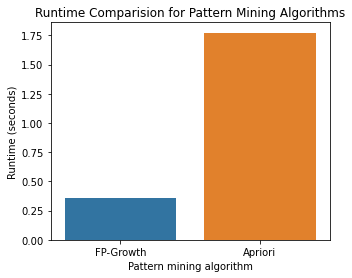

In [18]:
# importing library to evaluate execution 
import time

# getting runtime for FP-growth algorithm
start_time = time.time()
freq_items = get_frequent_itemset(train_data, 
                    algorithm="fp-growth",
                    min_support=0.0006)
fp_growth_time = time.time() - start_time

# getting runtime for Apriori algorithm
start_time = time.time()
freq_items = get_frequent_itemset(train_data, 
                    algorithm="apriori",
                    min_support=0.0006)
apriori_time = time.time() - start_time

# printing execution times
print('Execution time for fp-growth algorithm : ', fp_growth_time)
print('Execution time for apriori algorithm : ', apriori_time)

plt.figure(figsize=(5,4))
sns.barplot(x=["FP-Growth", "Apriori"],
            y=[fp_growth_time, apriori_time])

# adding labels to axes
plt.xlabel("Pattern mining algorithm")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime Comparision for Pattern Mining Algorithms")
plt.savefig("runtime.png")

From above plot we see that FP-Growth is more that twice as fast as the Apriori for identical results. Therefore, we will be using FP-Grwoth to mine frequent itemsets in our implementation. 

In [19]:
# The minimum support threshold is set as 0.0006, which is set by our statistical analysis at the last session
freq_items = get_frequent_itemset(train_data, min_support=0.0006)

# viewing the frequent itemsets
freq_items

,support,itemsets
0,0.039781,(pastry)
1,0.064312,(yogurt)
2,0.045249,(sausage)
3,0.074095,(soda)
4,0.006762,(pickled vegetables)
...,...,...
644,0.000647,"(hard cheese, soda)"
645,0.000647,"(other vegetables, hard cheese)"
646,0.000935,"(whole milk, semi-finished bread)"
647,0.000647,"(whole milk, seasonal products)"


A function to generate association rules form frequent itemsets

In [20]:
def get_association_rules(frequent_itemset: pd.DataFrame,
                         metric: str="confidence",
                         min_threshold: float=0.01,
                        lift_threshold: int=1):
    """
    Get the association rules
    
    Parameters:
        frequent_itemset: pd.DataFrame
            A dataFrame containing the frequent itemsets and the corresponding support 

        metric: str
            A string specifying the metric for getting association rules (e.g. confidence, lift)

        min_threshold: float
            A flaot number specifying the confidence threshold for getting association rules

        lift_threshold: int
            An integer specifying filtering our all the association rules with lift less than this threshold

    return:
        dictionary
            A dictionary containing the association rules. The key is the antecedents, the value is a list of tuple 
            with (consequents, confidence value)
    """

    # Getting the association rules     
    associations = association_rules(frequent_itemset, 
                  metric=metric, 
                  min_threshold=min_threshold)
    
    # choosing rules with lift > lift_threshold
    associations = (associations
                [associations['lift'] > lift_threshold]
                .reset_index(drop=True))
    
    # define the association rules dictionary
    rules_set = {}

    for index, itemset in associations.iterrows():
        item1, item2 = list(itemset["antecedents"])[0], list(itemset["consequents"])[0]
        rules_set[item1] = rules_set.get(item1, []) + [(item2, itemset["confidence"])]

    # sorting each list by the metric
    for antecedent in rules_set:
        rules_set[antecedent] = sorted(rules_set[antecedent], 
                                       key=lambda x: x[1],
                                       reverse=True)
        
    return rules_set


Viewing the association rules

In [21]:
# Association rules identified from training data
import pprint

# generating the association rules
associations = get_association_rules(freq_items)

# pretty printing the mined rules for training data
pprint.pprint(associations)

{'UHT-milk': [('tropical fruit', 0.06698564593301436)],
 'beef': [('citrus fruit', 0.04087193460490463),
          ('brown bread', 0.04087193460490463),
          ('curd', 0.035422343324250684),
          ('frozen vegetables', 0.035422343324250684),
          ('butter', 0.0326975476839237),
          ('domestic eggs', 0.02997275204359673),
          ('pork', 0.02997275204359673),
          ('frankfurter', 0.02997275204359673),
          ('margarine', 0.02997275204359673),
          ('misc. beverages', 0.024523160762942777)],
 'berries': [('bottled water', 0.04761904761904761)],
 'beverages': [('bottled water', 0.05232558139534883)],
 'bottled beer': [('sausage', 0.05532786885245902),
                  ('frankfurter', 0.030737704918032786),
                  ('chocolate', 0.020491803278688527)],
 'bottled water': [('butter', 0.02900763358778626),
                   ('sugar', 0.01984732824427481),
                   ('white bread', 0.0183206106870229),
                   ('berries', 0.01

### Determining the support thresholds <a id="f2"></a>


An itemset is said to be frequent when it has a higher support than the chosen threshold. If two items have no association, then they will appear together at random in any basket with a probability $p$, as given in equation.

\begin{equation}
p = \binom{m}{2}\frac{1}{k^2}
\label{eq:1}
\end{equation}

where $k$ is the number of unique items in the dataset, and $m$ is the number of items in the basket. By analyzing the training dataset and consulting the management, we found that 4 is the median number of items present in a customer's basket. Approximating that every customer has $m=4$ items in their basket we can model the  distribution of number of times two items randomly appear together in a basket using a binomial distribution as given by equation \ref{eq:2}

\begin{equation}
P(X=x) = \binom{n}{x} p^x (1-p)^{n-x}
\label{eq:2}
\end{equation}

where,

$n$ is the total number of transactions, 

$p$ is probability of success as defined by equation,

$x$ is the number of transactions where the two items appeared together\\

Using the probability density function of a binomial distribution, we concluded that two items will not appear more than eight times if they do no have any association with a confidence level of 99\%.  Therefore, we found that a frequent itemset with more than minimum support threshold given by equation \ref{eq:3} can be confidently said to be associated.

\begin{equation}
\text{minimum support threshold}= \frac{8}{n} = \frac{8}{13901} \approx 0.0006
\label{eq:3}
\end{equation}

After finding the frequent itemsets based on a threshold greater than or equal to the minimum found above, we filter the generated association rules in two steps. First, we select the rule with lift greater than or equal to one, ensuring that the antecedent and consequent are occurring more often together than independently. Then, based on the business profit margins we pick rules with a confidence of more than 0.01, since it would make up a profitably large portion of given million transactions.

\subsection{Evaluation of Association Rules}
Association rules were generated for both the training and testing dataset. We evaluated the quality of association rules found by measuring the number of test association rules that were identified in training association rule as given in equation \ref{eq:4}. We observed a precision of 28.57%

\begin{equation}
\text{Association rules precision} = \frac{|\{Test_{I\rightarrow j}\} \cap \{Train_{I\rightarrow j}\}|}{|\{Test_{I\rightarrow j}\}|}
\label{eq:4}
\end{equation}

### Evaluating Association rules <a id="f3"></a>

To evaluate the quality of the association rules mined from the training set we will generate association rules from the testing set and see how many of the rules from test set were captured in training associaition rules

In [22]:
# Find the association rules for training data
association_rules_train = get_association_rules(get_frequent_itemset(train_data, min_support=0.0006))

# Find the association rules for testing data
association_rules_test = get_association_rules(get_frequent_itemset(test_data, min_support=0.0006))

Representing association rules as tuples of (antecedent, consequent)


In [23]:
# Function group each antecedents and consequents in a tuple
get_rule_tuples = lambda rule_set: [(key, item[0]) for key in rule_set for item in rule_set[key]]

# generating tuple pairs of (antecedent, consequent) for association rules
train_rules = get_rule_tuples(association_rules_train)
test_rules = get_rule_tuples(association_rules_test)

To evaluate to quality of association rule we will use precision

$$
Precision = \frac{|Test\cap Train|}{|Test|}
$$

where $Test$ is set of association rules in test set, and $Train$ is set of rules identified in training set

In [24]:
# Calculate the precision for association rules 
precision = 1 - len(set(test_rules) - set(train_rules))/len(set(test_rules))

# printing the precision
print("The percentage of test association rules which are identified in train association rules is : ",
      precision*100, "%")

The percentage of test association rules which are identified in train association rules is :  15.94202898550725 %


In [25]:
set(test_rules).intersection(set(train_rules))

{('brown bread', 'pork'),
 ('curd', 'sausage'),
 ('frozen vegetables', 'root vegetables'),
 ('frozen vegetables', 'sausage'),
 ('pork', 'brown bread'),
 ('root vegetables', 'frozen vegetables'),
 ('sausage', 'curd'),
 ('sausage', 'frozen vegetables'),
 ('sausage', 'white bread'),
 ('semi-finished bread', 'whole milk'),
 ('white bread', 'sausage')}

## Collaborative filtering <a id="s7"></a>

Since collaborative filter predict ratings for user-item interactions and our dataset does not have explicit ratings, we will use the frequency of times a user bought an items as the implied rating for the interaction. By doing so we believe that the model will have more information about how much a user prefers an item, over 0/1 encoding giving it better features to predict the missing ratings.

A function to pre-process the data for making it suitable for collaborative filtering, which adds quantity as rating for every user-item interaction

In [26]:
def preprocess_CF_data(data: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the data to be used by collaborative filtering algorithms
    
    Parameters:
        data : pd.DataFrame
            A DataFrame containing columns of "userID", "itemID", and "date"
        
    Returns:
        pd.DataFrame
            A DataFrame containing "userID", "itemID" and "rating"
    """
    
    return (data
            # selecting "userID" and "itemID" columns
            [["userID", "itemID"]]
            
            # creating a new rating column with values as 1 (quantity)
            .assign(rating = 1)
            
            # grouping data for each user and item to get 
            # quantity of item bought by user
            .groupby(by=["userID", "itemID"])
            .count()["rating"]
            
            # reset multi-index
            .reset_index())

## Collaborative filtering models <a id="f5"></a>

We will be training following collaborative filtering models and comparing the results for each
- **Baseline model** of random recommendations
    - A baseline model to compare trained models
- **K-Nearest Neighbours method**
    - A similarity based method to recommend items
- **Latent factor model (SVD)**
    - A feature based method to model the utility matrix

We will be using [Surprise](https://surpriselib.com/), a python library for building and analyzing recommender systems

In [27]:
# import the surpise utilities
import surprise
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import prediction_algorithms

### Baseline model  <a id="c1"></a>

For the baseline method we will be randomly recommending the items to the users to compare it to other trained models, using the normal distribution on ratings

In [28]:
def train_random_prediction_model(data: pd.DataFrame) -> surprise.AlgoBase:
    """
    Train a random prediction model for generating ratings
    
    Parameter:
        data : pd.DataFrame
            A DataFrame with "userID", "itemID", and "rating"
        
    Returns:
        surpise.AlgoBase
            A trained model to predict ratings of itemID for a userID
    """
    
    # initialize the model
    random_model = prediction_algorithms.random_pred.NormalPredictor()
    
    # prepare data for surprise library
    data = Dataset.load_from_df(data, Reader())
    
    # train the model
    random_model.fit(data.build_full_trainset())
    
    
    return random_model

Training the random model on preprocessed training data

In [29]:
# generating the random model
random_model = train_random_prediction_model(preprocess_CF_data(train_data))

### K-Nearest Neighbours based method <a id="c2"></a>

The similarity based based methods are of two kinds:
- User-user similarity
- Item-item similarity

We can always train both models and test which one performs better but to confirm our findings that the user-user similarity performs better for our case we will cluster the training data using Principal Component Analysis and visually see which similarity would be better to pick

#### Clustering <a id="q1"></a>

We will perform clustering to identify the meaningful similiary measure for the dataset

In [30]:
# importing the PCA functionality
from sklearn.decomposition import PCA

#### Item-Item similarity analysis

We will perform PCA on items to see if they cluster well in different groups

Text(0.5, 1.0, 'PCA of trainging items')

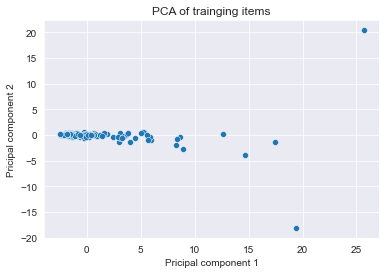

In [31]:
# generating item * users utiltiy matrix from training data
utility_matrix = (train_data_raw
                  .assign(date = pd.to_datetime(train_data_raw["Date"]),
                          userID = train_data_raw["Member_number"],
                          itemID = train_data_raw["itemDescription"])
                  [['userID', 'date', 'itemID']]
                  .assign(rating=1)
                  .pivot_table(values="rating", 
                               index="userID",
                               columns="itemID",
                               fill_value=0)
                  .to_numpy()
                  .transpose())

# performing PCA on training data
pca = PCA(n_components=5)
train_pca = pca.fit_transform(utility_matrix)

# visulazing the first 2 principal components of the data
sns.set_style("darkgrid")
sns.scatterplot(x=train_pca[:, 0],
                y=train_pca[:, 1])
plt.xlabel("Pricipal component 1")
plt.ylabel("Pricipal component 2")
plt.title("PCA of trainging items")

From above plot we see that there are no visible cluserting patterns among different items

#### User-User similarity analysis

No we turn to user-user clustering using PCA to identify any visible clustering patterns

Text(0.5, 1.0, 'PCA of trainging customers')

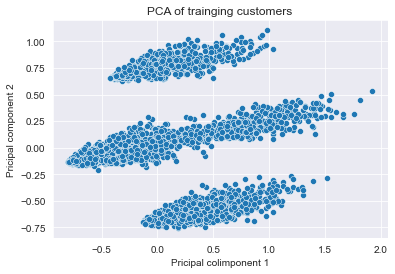

In [32]:
# generating user * items utiltiy matrix by transposing
utility_matrix = utility_matrix.transpose()

# performing PCA on training data
pca = PCA(n_components=5)
train_pca = pca.fit_transform(utility_matrix)

# visulazing the first 2 principal components of the data
sns.set_style("darkgrid")
sns.scatterplot(x=train_pca[:, 0],
                y=train_pca[:, 1])
plt.xlabel("Pricipal colimponent 1")
plt.ylabel("Pricipal component 2")
plt.title("PCA of trainging customers")

Based on the above two plots we can clearly see that users cluster better than the items in the training data, which means user-user similarity would be a better measure of similarity as we also found it to have a lower RMSE and MAE score

**Choice of cosine similarity:**
Since for a qunatity, unlike movie ratings 1 is not a bad score compared to 0. Which mean normalizing the data would make never bought items more preferable than items bought less times, therefore incorrectly encoding the user preference for the items. 

Hence, we decided to use cosine similarity without normalization to compute similarity scores. Unline jaccard similarity cosine similarity takes into account the measure of rating which is an important factor for recommender system.

#### KMeans clustering

Now that we have established user-user similarity is suitable for our database since we get meaningful clusters from it, we will perform k-means clustering and visualize the cluster using UMAP to see it the observed clusters exists when all features are taken into account

In [33]:
# importing the KMeans clustering utiltiy
from sklearn.cluster import KMeans

Based on our PCA analysis we found three distinct clusters of users and we will be using k=3 for our k-means clustering. Although we can tune the k and find more clusters but we want to use there clusters to personalize association rules generation for each customer, and then use it with collaborative filters to give personalized recommendations based on a user. Therefore, incereasing the number of clusters will not be 

In [34]:
# performing K mean
kmeans = KMeans(n_clusters=3,max_iter=100).fit(utility_matrix)

Plotting the users using Uniform Manifold Approximation and Projection (UMAP[[4]](#ref)) algorithm

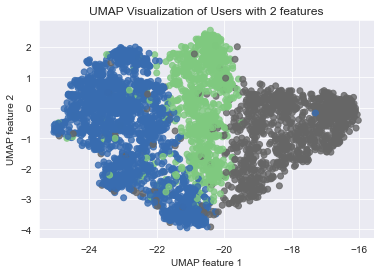

In [35]:
# importing the UMAP visualization library
import umap.umap_ as umap

# creating UMAP encoder object
reducer = umap.UMAP()

# fitting the training data to embedding
embedding = reducer.fit_transform(utility_matrix)

# plotting the UMAP features colored by the cluseter
plt.scatter(x=embedding[:, 0],
            y=embedding[:, 1],
            c=kmeans.predict(utility_matrix),
           alpha=0.8,
           cmap="Accent")

# adding axis information
plt.xlabel("UMAP feature 1")
plt.ylabel("UMAP feature 2")
plt.title("UMAP Visualization of Users with 2 features")
plt.savefig("UMAP.png")

From the above Visual we see that the 3 clusters are indeed well separated and represented well by the UMAP feature space. Therefore we will be using the above 3 groups

#### KNN Collaborative Filter implementation <a id="w1"></a>

In [36]:
# importing the KNN collaborative filter
from surprise import KNNBasic

A function to train the KNN based collaborative filter

In [37]:
def train_KNN_CF(data: pd.DataFrame,
                n_neighbors: int=20,
                similarity: str="cosine",
                user_based: bool=True) -> surprise.AlgoBase:
    """
    Train a nearest neighbors based collaborative filter
    
    Parameter:
        data : pd.DataFrame
            A DataFrame with "userID", "itemID", and "rating"
            
        n_neighbors : int, default 20
            Number of neighbors for calculating rating
            
        similarity : str, default "cosine"
            The similarity measure to be used for calculating
            similarity scores
            
        user_based : bool, default True
            Use user-user similarity to train if True
            
    Returns:
        surpise.AlgoBase
            A trained model to predict ratings of itemID for a userID
    """
    from surprise import KNNBasic
    
    # initialize the model
    knn_model = KNNBasic(k=n_neighbors,
                         sim_options={
                             "name": similarity,
                             "user_based": user_based
                         })
    
    # prepare data for surprise library
    data = Dataset.load_from_df(data, Reader())
    
    # train the model
    knn_model = knn_model.fit(data.build_full_trainset())
    
    return knn_model

Tuning the hyperparameter for number of neighbors for the KNN method using Grid Seach cross validation method

In [38]:
# hyperparameter values for KNN
knn_param_grid = {"k": list(range(20, 101, 10))}

# tuing the number of neighbors
knn_gs = GridSearchCV(KNNBasic, 
                      knn_param_grid,
                      measures=["rmse", "mae"],
                      cv=3)

# fitting the grid
knn_gs.fit(pipe(train_data, 
                preprocess_CF_data,
                lambda data: Dataset.load_from_df(data, Reader())))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [39]:
# best k value by RMSE and MAE
(knn_gs.best_estimator["rmse"].k, knn_gs.best_estimator["mae"].k)

(100, 40)

We will be useing RMSE to pick the hyperparameters since it will ensure the the preidcted ratings do not vary to far way from the actual rating, since it penalized square of the deviation unlike MAE which applied penalty linearly

In [40]:
# generating trained KNN user-based collaborative filter with best hyperparameters
knn_model = pipe(train_data, 
                 preprocess_CF_data,
                 lambda data: train_KNN_CF(data, 
                                           n_neighbors=knn_gs.best_estimator["rmse"].k))

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [41]:
# generating trained KNN item-based collaborative filter with best hyperparameters
knn_Imodel = pipe(train_data, 
                 preprocess_CF_data,
                 lambda data: train_KNN_CF(data, 
                                           n_neighbors=knn_gs.best_estimator["rmse"].k,
                                           user_based=False))

Computing the cosine similarity matrix...
Done computing similarity matrix.


### Singular Value Decomposition  <a id="w2"></a>

SVD is latent factor based model that tried to learn the latent features from utiltiy matrix, and decomposes it to smaller constituents [[1]](#ref). We will use the grid search technique to tune the number of latent features hyperparameter when we train it on the imputer utility matrix.

In [42]:
# importing the SVD library
from surprise import SVD

A function to train Singular Value Decompostion based Collaborative filter

In [43]:
def train_SVD_CF(data: pd.DataFrame,
                n_factors: int=20,
                n_epochs: int=50) -> surprise.AlgoBase:
    """
    Train a nearest neighbors based collaborative filter
    
    Parameter:
        data : pd.DataFrame
            A DataFrame with "userID", "itemID", and "rating"
            
        n_factors : int, default 20
            Number of latent factors to use
            
        n_epochs: int, default 50
            Number of epochs to train the SVD factorization
            
    Returns:
        surpise.AlgoBase
            A trained model to predict ratings of itemID for a userID
    """
    from surprise import SVD
    
    # initialize the model
    svd_model = SVD(n_factors=n_factors,
                    n_epochs=n_epochs)
    
    # prepare data for surprise library
    data = Dataset.load_from_df(data, Reader())
    
    # train the model
    svd_model.fit(data.build_full_trainset())
    
    return svd_model

Tuning the hyperparameter for number of latent factors in SVD model

In [44]:
# values for number of factors
svd_param_grid = {'n_factors': [5, 10, 25, 50, 100]}

# tuning the SVD using grid search
svd_gs = GridSearchCV(SVD, 
                      svd_param_grid,
                      measures=["rmse", "mae"],
                      cv=5)

# fitting the gird
svd_gs.fit(pipe(train_data, 
                preprocess_CF_data,
                lambda data: Dataset.load_from_df(data, Reader())))

In [45]:
# viewing best number of factors
(svd_gs.best_estimator["rmse"].n_factors, svd_gs.best_estimator["mae"].n_factors)

(5, 5)

Again, as mentioned in previous section we will be using RMSE to pick the hyperparameter

In [46]:
# training the SVD model with best hyperparameters
svd_model = pipe(train_data, 
                 preprocess_CF_data,
                 lambda data: train_SVD_CF(data, n_factors=svd_gs.best_estimator["rmse"].n_factors))

### Generating predictions <a id="s34"></a>

To generate predictions for a user, we will take the **userID** and optionally the current items in user's basket to provide top k predictions. We will further analyse the appropriate k while merging the system, for now we default it to 5, since that is the closer to the median number of items users buy from the store.

**Default behaviour for new users**  
The collaborative filter will recommend the most frequently bought products by all users to a new user, in order to reduce the cold start problem since we do not have any other information about the user, we rely on generic recommendations

In [47]:
# getting the list of unique items
ITEMS = list(train_data.itemID.value_counts().index)

A function to generate predictions from collaborative filter objects

In [48]:
def predict_CF(cf_model: surprise.AlgoBase, 
               user_id: int,
               item_ids: List=ITEMS,
               n_recommendations: int=5,
               current_basket: List=[]) -> List[Tuple[str, int]]:
    """
    Predicts the top k recommendations for a user
    
    Parameters:
        cf_model : surprise.AlgoBase
            A trained collaborative filter model
            
        user_id : int
            The user's ID for whom recommendations will be
            genrated
            
        item_ids : List, default ITEMS
            The list of items for which prediction is to be made
            default values of all items that are in training data
        
        n_recommendations : int
            Number of recommendations to be generated
            
        current_basket : List
            Items in current basket
    """
    
    # list to store predicted rankings
    ranks = []
    
    # predict ranks for all items
    for item in item_ids:
        ranks.append(cf_model
                     .predict(uid=user_id,
                              iid=item))
        
    # sort the ranks
    ranks.sort(key=lambda x: x.est,
               reverse=True)
    
    # list to store the final recommendations
    recommendations = []
    
    # getting the top k items from recommendations
    for item in ranks:
        # eliminating current basket items
        if item.iid not in current_basket:
            recommendations.append((item.iid, item.est))
                        
        # stop when k recommendations are found
        if len(recommendations) > n_recommendations:
            break
    
    return recommendations[:n_recommendations]

### Testing the collaborative filters <a id="s35"></a>

Since the collaborative filters produce a rating for each user and item pair we will compare the existing rating from predicted rating of the pair to evaluate the quality of fit for the collaborative filter.

To asess the quality of trained collaborative filters, we will compare the following metrics for models against each other and the baseline method

- Root mean suqared error
$$
RMSE = \frac{1}{n}\sum_{i=1}^n(\hat{y}_i-y_i)^2
$$
- Mean absolute error
$$
MAE = \frac{1}{n}\sum_{i=1}^n|\hat{y}_i-y_i|
$$

Since the collaborative filter generates numerical ratings, these metrics will evaluate how closely the model predicts the ratings. We will introduce other metrics later which will be used to test the final recommendations.

In [49]:
def evaluate_CF_metrics(data: pd.DataFrame,
                   cf_model: surprise.AlgoBase) -> dict:
    """
    Evaluate model efficiency for collaborative filters
    
    Parameters:
        data : pd.DataFrame
            Test dataframe with "userID", "itemID" and "ratings" columns
            
        cf_model : surprise.AlgoBase
            A trained collaborative filter model
    """
    
    rmse = 0
    mae = 0
    
    for index, row in data.iterrows():
        prediction = cf_model.predict(uid=row["userID"],
                            iid=row["itemID"]).est
        
        actual = row["rating"]
        
        rmse = rmse + (actual - prediction)**2
        mae = mae + abs(actual - prediction)
        
    
    return {
        'RMSE': (rmse/data.shape[0])**0.5,
        'MAE': mae/data.shape[0]
    }

### Generating recommendations from patterns

This section provides functions that can recommend items based on patterns. We use the existing items and association rules to recommend consequents whose antecedents are exisiting in the cart, and recommend the most frequently bought item when there is no item that can be recommended solely using patterns. We will be using this functionality to combine collaborative filters and patterns

Getting the ten most popular items in training set

In [50]:
TOP_10_ITEMS = list(train_data.itemID.value_counts()[:10].index)

A function to generate recommendations from patterns

In [51]:
def predict_rules(rule_set: dict,
                  current_basket: List,
                  n_recommendations: int = 5,
                  top_10_items: List = TOP_10_ITEMS,
                  user_id: int = 0) -> List[Tuple[str, int]]:
    """
    Predict the items user will buy based on their current basket
    and association rules. It current basket is empty we will rely
    on the most frequently bought items
    
    
    Parameters:
        rule_set : dict
            The learnt association rules
            
        current_basket : List
            List of items in current basket
            
        n_recommendations : List
            Number of recommendations
            
        top_10_items : List
            List of top 10 most frequntly bought items
            
        user_id : int, default 0
            This paremeter is not used by the patterns, but 
            required to maintain consistency of API
            
    Returns:
        List
            A list of top k recommendations sorted 
            by confidence scores
    """
    
    # list to contain the recommendations
    recommendations = []
    
    # adding all consquents of current basket to recommendations
    for item in current_basket: 
        # getting empty list if antecedent item is not present
        recommendations += rule_set.get(item, [])
        
        
    # removing items in current basket from recommendations
    recommendations = list(filter(lambda x: x[0] not in current_basket, 
           recommendations))
    
    
    # keeping consequents with higher confidence while eliminating duplicates
    unique_dict = {}
    for item, confidence in recommendations:    
        # keeping the higher confidence for duplicate consequents
        if confidence > unique_dict.get(item, 0):
            unique_dict[item] = confidence
       
    # creating list of uniqe items recommendations
    recommendations = [(item, conf) for item, conf in unique_dict.items()]
    
    # sorting the recommendations based on confidence
    recommendations.sort(key=lambda x: x[1],
                        reverse=True)
    
    # if current basket could not generate enough recommendations
    # from association rules we recommend most frequently bought items
    if len(recommendations) < n_recommendations:
        
        # filter already added items
        recommendations += [(i,0) for i in top_10_items[:n_recommendations - len(recommendations)]]
        
    return recommendations

## Proposed approach <a id="s8"></a>

Collaborative filters suffer mainly from following four problems:

- Cold Start
    - The system should have enough users to find a match
- Sparsity
    - The utility matrix does not have enough entires
- First rater
    - Cannot recommend an item that has not been previously rated	
- Popularity bias
    - Tends to recommned popular items
    
    
We propose a method to alleviate the sparsity problem by imputing the utility matrix using clusterd association rules, to avoid popularity bias and allow collaborative filter to perform better.

#### Utility functions

A function to get mapping of users to their respective cluster group

In [52]:
def map_user_to_cluster(clusterModel: KMeans,
                       utility_matrix: pd.DataFrame) -> dict:
    """
    Generate a mapping for a user to its cluster number
    
    Parameters:
        clusterModel: KMeans
            A trained model for clustering users
            
        utility_matirx: pd.DataFrame
            Utility matrix of user * items
    
    Returns:
        dict
            A dictionary with userID:cluster items
    """
    
    # stores mapping of userID to cluster
    user_cluster_mapping = {}

    # map each user to their appropriate cluster
    for userID, cluster in zip(utility_matrix.index, kmeans.predict(utility_matrix.to_numpy())):
        user_cluster_mapping[userID] = cluster
        
    return user_cluster_mapping
    

Filling sparsity based on found association rules

In [53]:
def clustered_association_rules(clusterModel: KMeans,
                               data: pd.DataFrame) -> List[dict]:
    """
    Generate association rules for based on each cluster of users
    
    Parameters:
        clusterModel: KMeans
            A trained clustering model on data
            
        data: pd.DataFrame
            A data fram
        
    """
    
    # generate utility matrix
    utility_matrix = generate_utility_matrix(data)
    
    # stores mapping of userID to cluster
    user_cluster_mapping = map_user_to_cluster(clusterModel,
                                              utility_matrix)
        
    # generate association rules for each cluster
    cluster_association_rules = []

    # generate association rules for each cluster
    for cluster in range(clusterModel.n_clusters):

        # getting users for ith cluster
        user_i_clusters = [user for user, c in  user_cluster_mapping.items() if c == cluster]

        # getting frequent itemset for ith cluster
        freq_items_i = get_frequent_itemset(train_data[train_data["userID"].isin(user_i_clusters)], 
                        algorithm="fp-growth",
                        min_support=0.0006)

        # getting association rules
        association_rules_i = get_association_rules(freq_items_i)

        # add association rules
        cluster_association_rules.append(association_rules_i)

    return cluster_association_rules    

In [54]:
clustered_association_rules(kmeans, train_data)

[{'whole milk': [('newspapers', 0.375),
   ('yogurt', 0.3),
   ('sausage', 0.2727272727272727),
   ('bottled water', 0.2666666666666666),
   ('fruit/vegetable juice', 0.23076923076923075),
   ('pastry', 0.23076923076923075),
   ('whipped/sour cream', 0.19999999999999998),
   ('shopping bags', 0.1875),
   ('domestic eggs', 0.18181818181818182),
   ('beef', 0.16666666666666666),
   ('yogurt', 0.15),
   ('rolls/buns', 0.15),
   ('hamburger meat', 0.15),
   ('rolls/buns', 0.15),
   ('rolls/buns', 0.13043478260869565),
   ('citrus fruit', 0.13043478260869565),
   ('pork', 0.12903225806451613),
   ('citrus fruit', 0.125),
   ('rolls/buns', 0.12),
   ('yogurt', 0.12),
   ('rolls/buns', 0.11111111111111112),
   ('rolls/buns', 0.1081081081081081),
   ('yogurt', 0.10714285714285714),
   ('sausage', 0.10714285714285714),
   ('sausage', 0.10526315789473684),
   ('coffee', 0.10526315789473684),
   ('pastry', 0.10344827586206896),
   ('newspapers', 0.10344827586206896),
   ('rolls/buns', 0.103448275

A function to populate training data using the association rules learnt for each cluster

In [59]:
def populate_training_data(clustered_association_rules: List[dict],
                          data: pd.DataFrame,
                          clusterModel: KMeans,
                          impute_rating: int = 1) -> pd.DataFrame:
    """
    Reduces the sparsity in data for better training of 
    collaborative filters
    
    Parameters:
        clustered_association_rules: List[dict]
            A list containing association rules for each cluster group

        data: pd.DataFrame
            A dataframe containing "userID" and "itemID" for each purchase
            
        clusterModel: KMeans
            A cluster model trained on the data
            
        impute_rating: int, default 1
            The rating to impute for based on association rules
            
    Returns:
        pd.DataFrame
            A dataframe with similar format as input data
            with reduce sparsity using the association rules
    """
    
     # generate utility matrix
    utility_matrix = generate_utility_matrix(data)
    
    # stores mapping of userID to cluster
    user_cluster_mapping = map_user_to_cluster(clusterModel,
                                              utility_matrix)
    
    # store mappings of rules with (antecedent, consquent) tuples
    mappings = []
    
    # generate (antecedent, consquent) tuples for each cluster
    for rules in clustered_association_rules:
        
        # mapping of the rules
        mapping = {}
        
        # generating pairs for the ith cluster
        for antecedent, items in rules.items():
            mapping[antecedent] = [item for item, _ in items]
            
        # append the association rule for ith cluster to list
        mappings.append(mapping)
    
    
    # filling utility matrix using association rules
    for index, row in utility_matrix.iterrows():
        
        # itering for every item in a row
        for name, item in row.items():
            
            # checking if item is present in the utility matrix
            if item >= 1 and name in mappings[user_cluster_mapping[index]]:
                
                # iterating over all consequents for the item
                for item_i in mappings[user_cluster_mapping[index]][name]:
                    
                    # checking if item is associated and setting rating to 1
                    if row[item_i] == 0:
                        
                        # imputing the rating
                        row[item_i] = impute_rating

    # converting utility matrix to expected long format
    filled_df = utility_matrix.reset_index().melt(id_vars=['userID'])
    filled_df = filled_df[filled_df["value"] > 0]
    
    return filled_df

Using the sparsity reduction method on the training data

In [64]:
# generating sparsity reduced utility matrix
utility_mat_imputed = populate_training_data(clustered_association_rules(kmeans, train_data),
                      train_data,
                      kmeans)

Training the models Collaborative Filters with imputed utility matrix

In [65]:
# train KNN model
knn_model_imputed = train_KNN_CF(utility_mat_imputed)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [66]:
# calculating the metrics for proposed model
evaluate_CF_metrics(preprocess_CF_data(test_data),
                    knn_model_imputed)

{'RMSE': 0.18858353935902247, 'MAE': 0.033105022831050226}

# Testing utility for recommender system <a id="s5"></a>


Since the test set does not provide explicit ratings to the items, making ordering of items using quantity bought unreliable, we chose to use 0/1 model testing metrics [[2]](#ref) to access the quality of generated:

- Precision
$$
Precision = \frac{\#\ of\ correct\ predictions}{\#\ of\ total\ predictions}
$$

- Coverage
$$
Coverage = \frac{\#\ of\ correct\ predictions}{\#\ of\ bought\ items}
$$

We consider a basket/transaction as the items bought by a customer on a day, and evaluate it based on this model of the basket. We decided to keep a day as the basket size as the items bought during the same day are more likely to be bought together in same transaction.

A utility function to evaluate the various trained recommender systems

This function will be used to evaluate various methods of combined recommender systems when the code is integrated for final models for recommendation generation.

In [67]:
def evaluate_recommender(model,
                         prediction_func: Callable,
                         train_data: pd.DataFrame,
                         test_data: pd.DataFrame,
                         n_recommendations: int=5,
                         rule_set: dict = {}) -> dict:
    """
    Produce coverage and precision metrics for recommender systems
    
    Parameters:
        model: 
            Trained model capable of generating recommendations
            
        prediction_func: Callable
            Function that takes model as input to generate recommendations
            
        train_data : pd.DataFrame
            A dataframe with "userID", "data", and "itemID" columns
            used to train the model
            
        test_data : pd.DataFrame
            A dataframe with "userID", "data", and "itemID" columns
            to test the trained model
            
        n_recommendations: int
            The number of recommendations to be generated
            
        rule_set : dict, default {}
            Association rules learnt on train_data
            
    Returns:
        dict
            A dictionary containing coverage and precision(accuracy)
            metric for the trained model as evaluated of test data
    """
    
    # function to generate baskets from data
    generate_baskets = lambda data: (data
                                     .groupby(by=['userID', 'date'])
                                     .agg(lambda x: list(x)))
    
    # generating baskets for train and test data
    train_baskets = generate_baskets(train_data)
    test_baskets = generate_baskets(test_data)
    
    # initializing the metric counters
    hits = 0
    misses = 0
    total_bought = 0
    total_predictions = 0
    
    # progress tracker
    progress = 0
    
    # generate recommendations and evaluate metrics
    for basket in test_baskets.iterrows():
        # initialise empty basket
        current_basket = []
        
        # get the existing items in the basket
        try:
            current_basket = train_baskets.loc[basket[0][0], basket[0][1]]["itemID"]
        except:
            pass
        
        # contents in testing basket
        test_basket = basket[1]["itemID"]
        
        # generating recommendations
        recommendations = prediction_func(model, 
                                          user_id=basket[0][0],
                                          n_recommendations=n_recommendations,
                                          current_basket=current_basket)
    
        # keeping only the items
        recommendations = [item for item, _ in recommendations]
        
        # accumulating the hits and misses
        hits += len(set(test_basket).intersection(set(recommendations)))
        misses +=len(set(test_basket) - set(recommendations))
        total_bought += len(set(test_basket))
        total_predictions += n_recommendations
                
        # printing progress
        print(f"Progress: {progress/len(test_baskets)*100:0.2f}%, hits:{hits}", end="\r")
        progress += 1
            
    return {
        "Precision": hits/total_predictions,
        "Coverage": hits/total_bought
    }

Evaluating the baseline model

In [68]:
# getting metrics from random prediction model
baseline_metrics = evaluate_recommender(random_model,
                     predict_CF,
                    train_data,
                    test_data)

baseline_metrics

{'Precision': 0.007637068277670124, 'Coverage': 0.028612914246668945}

Evaluating collaborative filters without imputation

In [69]:
# getting metrics from knn user-based model without imputation
knn_metrics = evaluate_recommender(knn_model,
                     predict_CF,
                    train_data,
                    test_data)

knn_metrics

{'Precision': 0.05250199475663969, 'Coverage': 0.19670310898530918}

In [70]:
# getting metrics from knn item-based model without imputation
knn_Imetrics = evaluate_recommender(knn_Imodel,
                     predict_CF,
                    train_data,
                    test_data)

knn_Imetrics

{'Precision': 0.02528211558189901, 'Coverage': 0.09472155790912197}

In [71]:
# getting metrics from svd model without imputation
svd_metrics = evaluate_recommender(svd_model,
                     predict_CF,
                    train_data,
                    test_data)

svd_metrics

{'Precision': 0.05979710475322011, 'Coverage': 0.2240348479672019}

Evaluating the imputed collaborative filters

In [72]:
# getting metrics from knn model with imputation
knn_model_imputed_metrics = evaluate_recommender(knn_model_imputed,
                     predict_CF,
                    train_data,
                    test_data)

knn_model_imputed_metrics

{'Precision': 0.06084577681522854, 'Coverage': 0.227963785445849}

## Results <a id="s9"></a>

Since it was observed that the median number of items bought by a user is 4 we decided to recommend 5 items to the user, the number of recommendation is a configurable parameter which can be changed as the business changes

### Evaluating Model Fit using RMSE and MAE <a id="r1"></a>

In [73]:
# creating list of all models
cf_models = [("Random", random_model), 
             ("KNN-item", knn_Imodel),
             ("KNN-user", knn_model), 
             ("SVD", svd_model), 
             ("KNN-user-imputed", knn_model_imputed)]

# dataframe to store metrics
metrics = pd.DataFrame({"RMSE":[], "MAE": []})

# preprocessing the data
cf_test_data = preprocess_CF_data(test_data)

for name, model in cf_models:
    
    # evaluating the model
    evaluation = evaluate_CF_metrics(cf_test_data,
                        model)

    # adding metrics to dataframe
    metrics = metrics.append(pd.Series({"RMSE": evaluation["RMSE"], 
                              "MAE": evaluation["MAE"]},
                             name=name))
    
metrics

,RMSE,MAE
Random,0.305054,0.187505
KNN-item,0.229822,0.110154
KNN-user,0.200807,0.106279
SVD,0.212274,0.117458
KNN-user-imputed,0.188584,0.033105


C:\Users\Ankush\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Ankush\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


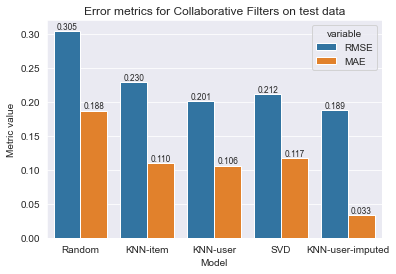

In [74]:
# plt.figure(dpi = 100) 
sns.set_style("darkgrid")
ax = sns.barplot(data=(metrics
                  .reset_index()
                  .melt(id_vars="index",value_vars=["RMSE", "MAE"])),
            x="index",
            y="value",
            hue="variable")

for i in ax.containers:
    ax.bar_label(i, fmt="%0.3f", size='small')

plt.xlabel("Model")
plt.ylabel("Metric value")
plt.title("Error metrics for Collaborative Filters on test data")
plt.savefig("evaluationmetric.png")

#### Evaluating quality of recommendations <a id="r2"></a>

Evaluating the quality of top 5 recommendations generated using coverage and precision

In [75]:
# creating list of all models
cf_models = [("Random", random_model), 
             ("KNN-item", knn_Imodel),
             ("KNN-user", knn_model),  
             ("SVD", svd_model), 
             ("KNN-user imputed", knn_model_imputed)]

metrics = pd.DataFrame({"Precision":[], "Coverage": []})

cf_train_data = preprocess_CF_data(train_data)

for name, model in cf_models:
    
    # evaluating the model
    evaluation = evaluate_recommender(model,
                                      predict_CF,
                                      train_data,
                                      test_data)

    # adding metrics to dataframe
    metrics = metrics.append(pd.Series({"Precision": evaluation["Precision"], 
                              "Coverage": evaluation["Coverage"]},
                             name=name))
    
metrics

,Precision,Coverage
Random,0.008230,0.030834
KNN-item,0.025282,0.094722
KNN-user,0.052502,0.196703
SVD,0.059797,0.224035
KNN-user imputed,0.060846,0.227964


C:\Users\Ankush\anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Ankush\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


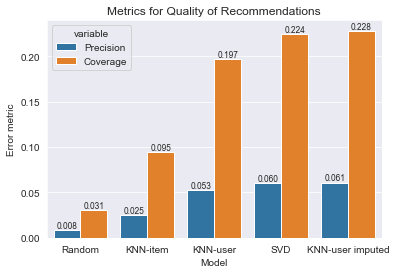

In [76]:
sns.set_style("darkgrid")
plt_data = (metrics
            .reset_index()
            .melt(id_vars="index",value_vars=["Precision", "Coverage"]))
ax = sns.barplot(data=plt_data,
            x="index",
            y="value",
            hue="variable")

for i in ax.containers:
    ax.bar_label(i, fmt="%0.3f", size='small')
    
plt.xlabel("Model")
plt.ylabel("Error metric")
plt.title("Metrics for Quality of Recommendations")
plt.savefig("recommendationmetric.png")

#### Statistical T-test to see if the proposed model is actually better than SVD <a id="r3"></a>

We will conduct t-test to determine the the observed better performance of proposed model is statiscally significant [[3]](#ref)

In [77]:
# generating difference between predictions
diff = []
for index, row in test_data.iterrows():
    
    # getting knn model rating
    knn_pred = knn_model_imputed.predict(uid=row["userID"],
                                         iid=row["itemID"])
    
    # getting svd model rating
    svd_pred = svd_model.predict(uid=row["userID"],
                                 iid=row["itemID"])
    
    # appending the difference
    diff.append(knn_pred.est - svd_pred.est)
    
    # printing the progress
    print(f"count {index}", end='\r')

Using the difference in rating generated to identify if it is statistically significant using a t-test

In [78]:
#Comopute the mean of differences
d_bar = np.mean(diff)

#compute the variance of differences
sigma_sq = np.var(diff)

#compute the number of data points used for training 
n1 = len(train_data)

#compute the number of data points used for testing 
n2 = len(test_data)

#compute the total number of data points
n = n1 + n2

#compute the modified variance
sigma_sq_mod = sigma_sq * (1/n + n2/n1)

#compute the t_static
t_static =  d_bar / np.sqrt(sigma_sq_mod)

In [80]:
# importing the t-distribution
from scipy.stats import t

# generate the confidence interval
t.ppf(0.10, n-1), t.ppf(0.90, n-1)

(-1.281573405382972, 1.2815734053829722)

In [81]:
# observed t-statistic
t_static

-1.3770358021292208

We observe that the observed value for t-statistic is not within the range of expected value, therefore we can say the proposed model performed better than the SVD model with a confidence level of 90%.

## Prediction samples <a id="r4"></a>

We use our model to make some predictions for random user, and see if they are as expected.

In [82]:
# 5 random users
users = [1000, 2001, 2022, 2103, 3004]

# two baskets with some items in them
basket = [['rolls/buns', 'whole milk'], ['sausage', 'root vegetables', 'other vegetables']]

# generating recommendation for every user, basket pairs
for u in users:
    for b in basket:
        print(u, b)
        print("{", end="")
        [print(i, end=",") for i,_ in predict_CF(knn_model_imputed,user_id=u, current_basket=b)]
        print("\b ", end="")
        print("\b}")
        print()

1000 ['rolls/buns', 'whole milk']
{other vegetables,soda,yogurt,root vegetables,tropical fruit}

1000 ['sausage', 'root vegetables', 'other vegetables']
{whole milk,rolls/buns,soda,yogurt,tropical fruit}

2001 ['rolls/buns', 'whole milk']
{other vegetables,soda,yogurt,root vegetables,tropical fruit}

2001 ['sausage', 'root vegetables', 'other vegetables']
{whole milk,rolls/buns,soda,yogurt,tropical fruit}

2022 ['rolls/buns', 'whole milk']
{other vegetables,soda,yogurt,root vegetables,tropical fruit}

2022 ['sausage', 'root vegetables', 'other vegetables']
{whole milk,rolls/buns,soda,yogurt,tropical fruit}

2103 ['rolls/buns', 'whole milk']
{other vegetables,soda,yogurt,root vegetables,tropical fruit}

2103 ['sausage', 'root vegetables', 'other vegetables']
{whole milk,rolls/buns,soda,yogurt,tropical fruit}

3004 ['rolls/buns', 'whole milk']
{other vegetables,soda,yogurt,root vegetables,tropical fruit}

3004 ['sausage', 'root vegetables', 'other vegetables']
{whole milk,rolls/buns,soda

## Discussion <a id="s10"></a>

We observed that the sparsity problem in training collaborative filters can be effectively alleviated by making use of explainable association rules. In the frequent itemsets mining, we can adopt a parallel FP-growth algorithm which would result in enhanced performance of the system.

Moreover, by clustering the users we were able to reduce the sparsity for each user in a more personalized way than using global association rules. To cluster the users PCA was used for our implementation, we want to explore the use of density-based clustering algorithms to automate the grouping discovery.

To impute the ratings we used the lowest score in order to avoid any bias, but further exploration of the imputed rating using association rules can lead to more accurate imputations.

Finally, time plays an important role in ever-changing user preferences, currently, the frequent retraining of the system handles the changing preferences but in the future, we would like to incorporate time-sensitive collaborative filtering methods which can reduce the frequent refresh of the system and possibly predict the change in preferences over time.

Future works include the improvements in our recommendation system as follows:

In the frequent itemsets mining, we can adopt a parallel fp-growth algorithm that utilizes multiple processors to mine frequent itemsets in parallel to further reduce the execution time. 

In the choice of the clustering algorithm, we can use density-based clustering algorithms such as DBSCAN which are able to remove outliers and identify clusters of different sizes automatically without the need for specifying the number of clusters beforehand. 

We can also include the time factor in weighting our transactions. In our dataset, we have transactions from 2014 to 2015. More recent transactions can be weighted higher as they are more representative in terms of a purchasing pattern. This can further increase the prediction accuracy of our recommendation system.

## Deployment and Scalability <a id="s11"></a>

To find the frequent itemset, we use FP-growth which takes linear time with respect to the number of transactions and the generated utility matrix can be imputed in linear time based on the number of user-item pairs in the system. Furthermore, training the user-based KNN model will require $O(M^2*N*k)$ where $M$ is the number of users, $N$ is the number of items, and $k$ is the number of neighbours for finding similar users. Based on the running times our system can be trained. Based on the times observed, we can compute that training the whole system on an average AWS (Amazon Web Services) instance, with a frequency of 20GHz, when we have a million transactions would be nearly 2 hours, given that the training data is representative of the overall load of the system.

To analyze the space complexity, we consider the main memory required for the algorithm to run. The FP-growth used a tree representation to store itemsets requiring $O(N^2)$ space, and the majority of the space is utilized by the utility matrix which would be $O(M*N)$, lastly to store the similarity matrix for the collaborative filter will require $O(M^2)$ space. Based on the above space complexity evaluations, we can compute that if each entry is stored in a floating point number, then the deployment server would require nearly 12GB of main memory to perform the calculation, but once the model is trained we only need to store the nearest neighbors for the users, which required far less memory.

Based on the above numbers, we can conclude that the system can scale to a million transactions with a server running at 20GHz (average AWS frequency), with nearly 12GB of memory. The server can also be refreshed daily with another parallel instance, generating relevant recommendations for users every day.

Once the model is train following function can be used to generate predictions

In [84]:
# prediction method example
predict_CF(knn_model_imputed,
           user_id=1000, 
           current_basket=['whole milk'])

[('sausage', 1.27),
 ('root vegetables', 1.18),
 ('other vegetables', 1.15),
 ('soda', 1.14),
 ('rolls/buns', 1.13)]

## References <a id="ref"></a>

1. Yuan, X., Han, L., Qian, S., Xu, G. and Yan, H., 2019. Singular value decomposition based recommendation using imputed data. Knowledge-Based Systems, 163, pp.485-494.
2. Slides MMDS http://www.mmds.org/mmds/v2.1/ch09-recsys1.pdf
3. T-test to compare models: https://medium.com/analytics-vidhya/using-the-corrected-paired-students-t-test-for-comparing-the-performance-of-machine-learning-dc6529eaa97f
4. UMAP visualization https://towardsdatascience.com/umap-dimensionality-reduction-an-incredibly-robust-machine-learning-algorithm-b5acb01de568